In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [9]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
ALPHAMISSENSE_SCORES = "../data/datasets/AlphaMissense_hg19.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output dir
RESULTS_DIR = "../results/PCAWG"
os.makedirs(RESULTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types with driver genes
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.remove("Pancancer")
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [10]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [11]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
	df["cancer_type"] = cancer_type
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	df = df[df["gene"].isin(driver_genes_list)]
	df = pd.merge(df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
	mut_df = pd.concat([mut_df, df])

print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98764/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98764/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98764/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98764/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read

(90258, 15)
(82512, 15)


In [12]:
am_scores_df = pd.read_csv(ALPHAMISSENSE_SCORES, sep="\t", skiprows=3)
print(am_scores_df.shape)
am_scores_df["mutation_loc"] = am_scores_df["#CHROM"].astype(str) + ":" + am_scores_df["POS"].astype(str) + ":" + am_scores_df["REF"].astype(str) + ":" + am_scores_df["ALT"].astype(str)
am_scores_df["mutation_loc"] = am_scores_df["mutation_loc"].str.replace("chr", "")
am_scores_df = am_scores_df[["mutation_loc", "am_pathogenicity", "am_class"]]
am_scores_df.drop_duplicates(subset=["mutation_loc"], inplace=True)
print(am_scores_df.shape)

mut_df = pd.merge(mut_df, am_scores_df, on="mutation_loc", how="left")
print(mut_df.shape)

(69716655, 10)
(69124190, 3)
(82512, 17)


In [13]:
# filter out indels, MNVs and non-coding mutations without Alphamissense scores
print(mut_df.shape)
mut_df = mut_df[mut_df["am_pathogenicity"].notnull()]
print(mut_df.shape)
mut_df.reset_index(inplace=True)
print(mut_df.shape)

# normalize Alphamissense scores for each gene
mut_df["am_score_normalized"] = mut_df.groupby("gene")["am_pathogenicity"].transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)

# get driver status
mut_df["has_driver"] = mut_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
mut_df["has_driver"] = mut_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)

(82512, 17)
(2558, 17)
(2558, 18)


## Distribution of Alphamissense scores

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Passengers in presence of driver vs. Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:8.585e-03 U_stat=2.708e+04
Passengers in absence of driver vs. Drivers: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:4.580e-07 U_stat=5.735e+05


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98764/3682575745.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(


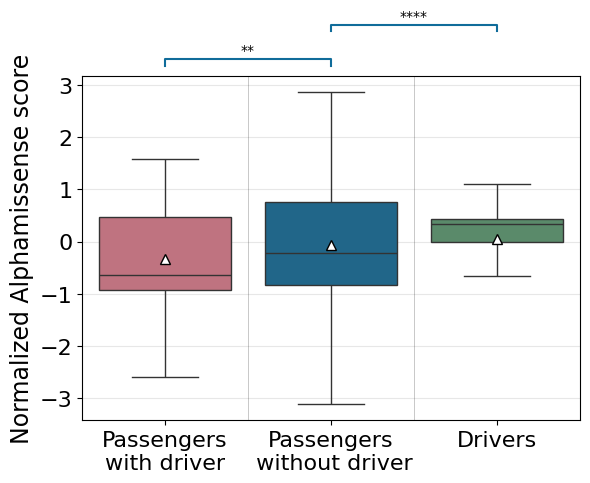

In [14]:
plt.figure(figsize=(6, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
ax1 = sns.boxplot(
    x="has_driver",
    y="am_score_normalized",
    data=mut_df,
    order=order,
    palette=cmap,
    showfliers=False,
    showmeans=True,
	meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"7"}
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(order) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

plt.xlabel("")
plt.xticks(fontsize=16, labels=["Passengers\nwith driver", "Passengers\n without driver", "Drivers"], ticks=[0, 1, 2])
plt.ylabel("Normalized Alphamissense score", fontsize=17)
plt.yticks(fontsize=16)

# get statistical significance annotations
box_pairs = [("Passengers in absence of driver", "Passengers in presence of driver"), 
             ("Passengers in absence of driver", "Drivers")]
annotator = Annotator(
    ax1, 
    x="has_driver", 
    y="am_score_normalized",
    order=order,
    data=mut_df, 
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', hide_non_significant=True, color=colors[0], loc='outside')
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', hide_non_significant=True, color=colors[1], loc='outside')
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/alphamissense_score_distribution.png", dpi=300)

# source data
mut_df[["has_driver", "am_score_normalized"]].to_csv(f"{PLOT_DATA_DIR}/alphamissense_score_distribution.tsv", sep="\t", index=False)